In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [2]:
data_path = '/home/sile2804/data-ceph/arguana/arg-generation/argument-undermining/'

In [3]:
jo_df =  pd.read_pickle(data_path + "jo_data/gen_data.pickle")

training_df = jo_df[jo_df.split =='train']
valid_df = jo_df[jo_df.split =='val']

In [4]:
training_df.head()

,post_id,split,comment_id,title,post,comment,n_sentences,direct_sents,all_4_sents,comment_sents,premise_counter_premise_pairs,num_attacks
0,t3_1u4mmo,train,t1_ceei4mi,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]","&gt;I believe that a church is like any other profit making business and therefore most pay similar taxes. I am not a religious person myself so I do not know the complete logistics of the revenue and spending of a church but I do understand they can yield a good amount of cash. \n\nChurches, like all other non-profits, must make money to continue to exist. The difference between a non-profit and a for-profit is that all profits in a non-profit go to expand the core mission whereas profits in a for-profit can be distributed to the owners. Do you want to eliminate deductions for all nonprofits, or only for religious ones?",4,"[0, 1]",[],"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., churches, like all other non profits, must make money to continue to exist., the difference between a non profit and a for profit is that all profits in a non profit go to expand the core mission whereas profits in a for profit can be distributed to the owners., do you want to eliminate deductions for all nonprofits, or only for religious ones?]","[[[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash.], churches, like all other non profits, must make money to continue to exist. the difference between a non profit and a for profit is that all profits in a non profit go to expand the core mission whereas profits in a for profit can be distributed to the owners. do you want to eliminate deductions for all nonprofits, or only for religious ones?]]",1
1,t3_1u4mmo,train,t1_ceemale,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]","&gt; I believe that a church is like any other profit making business and therefore most pay similar taxes.\n\nTo the contrary, churches are not businesses and aren't for profit. The simplest answer is that they aren't taxed because not-for-profit organizations get tax exemptions. A church could randomly decide one day that it was no longer interested in religion and only wants to be a not-for-profit charity and their tax situation would be the same.\n\nOf course, with the benefits of tax exempt status comes regulation -- for example, they are not supposed to be involved in political campaigning.",4,[0],[],"[i believe that a church is like any other profit making business and t

In [3]:
def convert_df(df, path, sample=None):
    examples = []
    if sample is not None:
        df = df.sample(sample)
    
    for idx, post in df.iterrows():
        for attack in post['premise_counter_premise_pairs']:
            examples.append(
                {
                    'conclusion': post['title'],
                    'premises': post['post'],
                    'weak_premises': attack[0],
                    'counter' : attack[1],
                }
            )
    
    print('Number of examples: {}'.format(len(examples)))
    new_df = pd.DataFrame(examples)
    return new_df
    #json.dump(examples, open(path, 'w'))

In [6]:
new_training_df = convert_df(training_df, '../data/train.json')

Number of examples: 90426


In [7]:
new_valid_df = convert_df(valid_df, '../data/valid.json')

Number of examples: 29940


In [12]:
new_training_df.to_pickle('../data/train.pkl')
new_valid_df.to_pickle('../data/valid.pkl')

In [10]:
new_training_df.to_csv('../data/train.csv', index=False)
new_valid_df.to_csv('../data/valid.csv', index=False)

### Prepare data for conclusion comprehension for CA generation task:

In [3]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import nltk
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

from sentence_transformers import SentenceTransformer, util
import torch
model = SentenceTransformer('all-MiniLM-L6-v2')

In [4]:
def content_token_overlap(text1, text2):
    tokens1 = set([x for x in nltk.word_tokenize(text1.lower()) if x not in en_stopwords])
    tokens2 = set([x for x in nltk.word_tokenize(text2.lower()) if x not in en_stopwords])
    
    return round(len(tokens1.intersection(tokens2))/len(tokens1.union(tokens2)), 5)

In [8]:
df = pd.read_pickle(data_path + "jo_data/argument_rebuttals.pkl")

In [10]:
sample_df = df.sample(1000)

In [11]:
#sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: process.extract(x['title'], x['post'], scorer=fuzz.token_set_ratio, limit=500), axis=1)
sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: [(sent, content_token_overlap(x['title'], sent)) for sent in x['post']], axis=1)

In [47]:
#Compute semantic similarity
sample_df['conclusion_embeddings'] = model.encode(sample_df['title'].tolist()).tolist()
sample_df['premises_embeddings'] = sample_df['post'].apply(lambda x: model.encode(x))
sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: util.pytorch_cos_sim(torch.tensor(x['conclusion_embeddings']), 
                                                                                      torch.tensor(x['premises_embeddings'])
                                                                ).tolist()[0], axis=1)
sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: list(zip(x['post'], x['conclusions_in_argument'])), axis=1)

In [54]:
sample_df[['title', 'post', 'conclusions_in_argument']].head()

,title,post,conclusions_in_argument
290103,Shaming women for sleeping with many is no better than shaming men for sleeping with few,"[i see this a lot, where women say it's unfair to get shamed for sleeping around, but when men do they're praised for it, called a 'player', 'stud', etc., but nobody talks about how men get shamed for still being a virgin or 'not getting some', while women get praised for it., at the end of the day, aren't people getting shamed both ways for being themselves?, 'patriarchy' won't change my mind, as both are parties that are getting hurt., whether or not a guy being shamed is of the same gender that created the rules in the first place makes no difference to me, and i fail to see why it should., in my opinion, that's like saying people in the middle east shouldn't complain because their dictator shares the same nationality., the 'accusers' are both men and women as well, for either shaming., since both demographics are guilty of this, why should there be a difference?, going away for a bit, i'll probably read responses, though i can't promise to reply., thanks to everyone who took the effort to give me perspective!]","[(i see this a lot, where women say it's unfair to get shamed for sleeping around, but when men do they're praised for it, called a 'player', 'stud', etc., 0.5033611059188843), (but nobody talks about how men get shamed for still being a virgin or 'not getting some', while women get praised for it., 0.45310935378074646), (at the end of the day, aren't people getting shamed both ways for being themselves?, 0.32762911915779114), ('patriarchy' won't change my mind, as both are parties that are getting hurt., 0.33749765157699585), (whether or not a guy being shamed is of the same gender that created the rules in the first place makes no difference to me, and i fail to see why it should., 0.4704388380050659), (in my opinion, that's like saying people in the middle east shouldn't complain because their dictator shares the same nationality., 0.2672026753425598), (the 'accusers' are both men and women as well, for either shaming., 0.552834689617157), (since both demographics are guilty of this, why should there be a difference?, 0.336520254611969), (going away for a bit, i'll probably read responses, though i can't promise to reply., 0.10098472982645035), (thanks to everyone who took the effort to give me perspective!, 0.1411144733428955)]"
262589,"If you know your friend's significant other is cheating on her, you should not tell her.","[scenario: you have a close female friend., you find information that 100 demonstrates her significant other boyfriend, husband, girlfriend, wife is cheating on her., you should not tell her anything point blank., i once had a close friend whose boyfriend kept hitting on me for months., i finally told her., she didn't thank me., she said i was making it up because i wanted him for myself., she stopped speaking to me., a second time me and my friend karlie found out our friend's june's boyfriend was cheating and asking girls to come to his house to fuck him., we told june., june didn't believe us., we stayed friends but things got weird., third time broke the camel's back for me., i caught my best friend's boyfriend holding hands with another girl., i told her., he actually didn't deny it., they broke up., then she took him back., he was awkward around me afterwards., i know my experience may be anecdotal but 'shooting the messenger' is 100 real., people don't want to accept things that are painful., sometimes the truth is too painful to accept., instead of accepting it, they would rather shoot the messenger and hope that he she is lying rather than accept the truth., your friend is not going to want to believe her husband boyfriend is cheating., she's going to shoot you as the messenger., telling her risks damaging your friendship., 1 she's either not going to believe you., and or she'll turn it on you, shoot you as the messenger and that will affect your fri

In [55]:
similarity_dist = [cand[1] for cands in sample_df['conclusions_in_argument'].tolist() for cand in cands]

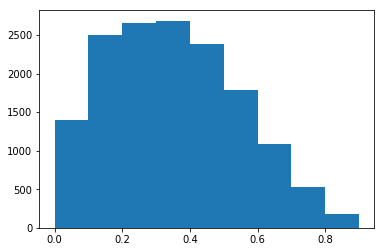

In [56]:
plt.hist(similarity_dist, bins=np.arange(0, 1, 0.1))
plt.show()

In [69]:
sample_df['top_conclusions_in_argument'] = sample_df['conclusions_in_argument'].apply(lambda item: [x for x in item if x[1] > 0.75])

In [70]:
len(sample_df[sample_df['top_conclusions_in_argument'].str.len() > 0])

294

In [71]:
sample_df[sample_df['top_conclusions_in_argument'].str.len() > 0][['title', 'top_conclusions_in_argument']].head(n=100)

,title,top_conclusions_in_argument
53431,I think Niccolo Machiavelli has an undeservedly poor reputation.,"[(it seems to me that niccolo machiavelli has an undeservedly poor legacy., 0.8205562829971313)]"
285839,I believe that sex education should be in the home from parents and not the jobs of educators at school.,"[(i think it shouldn t be the job of people at school to teach sex education because., 0.8578989505767822)]"
442976,"Dr. Phil and similar TV shows are the modern, socially acceptable equivalent of circus freak shows","[(shows like dr. phil are not much different from a freak show., 0.801140546798706)]"
435963,Transgender/trans-affirming people cannot define the word “man” or “woman”,"[(but so far, i have yet to hear a clear, meaningful definition of the term man or woman from someone who affirms transgenderism., 0.8030619025230408), (when i ask transgender trans affirming people for a definition, i typically get answers like this: a man is someone who says they are a man , a man is someone who experiences life as a man ., 0.7689554691314697)]"
392617,Nothing I can do as a cyclist will ever make drivers stop hating me.,"[(it seems like, no matter what i do, drivers will hate me and want me to stop riding., 0.7634909749031067), (i'm not going to stop, but it really feels like i'm doing everything that can be reasonably expected of a cyclist and drivers still hate me being on the road., 0.8047007322311401)]"
...,...,...
314122,Dark Souls isn’t as great of a game as everyone says it and the difficulty seems like a gimmick.,"[(i want to clarify a few things before i start: 1 i m in no way saying that dark souls is a bad game, just overrated., 0.7539910674095154), (now my argument is that the original dark souls is only rated so highly because a lot of mainstream games nowadays aren t very difficult., 0.782929003238678), (i do like it when a game is challenging but i m arguing that dark souls is only difficult because it creates unfair situations for the player., 0.8246773481369019)]"
41530,I believe a fetus has rights worth protecting.,"[(i simply believe that since there can be no informed decision made by the fetus, we have an obligation to protect it., 0.8215245008468628)]"
339971,"There should be no separate minimum wage for waiters or ""tipped"" employees. And tipping should not be a social ""expectation"" in pretty much every dining situation &amp; other places where tips are ""expected"" as a given. Waiters &amp; others should get paid a fair market wage by employers.","[(i think that waiters, hairdressers, valets, and other professions who have a tipping expectation should just be paid a fair market wage paid by their employers and there should be no pressure or expectation of tips from pretty much every customer., 0.8191947340965271)]"
467351,you have no moral obligation to disclose the fact that a meal is vegan to people eating it,"[(so, why should people have to 'disclose' that a meal is vegan?, 0.8401384949684143)]"


#### Mask conclusions in arguments:

In [5]:
df = pd.read_pickle(data_path + "jo_data/argument_rebuttals.pkl")

In [6]:
print(len(df))

541678


In [73]:
# df['conclusions_in_argument'] = df.apply(lambda x: [x[0] for x in process.extract(x['title'], x['post'], scorer=fuzz.token_set_ratio, limit=500) if x[1] > 50], axis=1)
# df['conclusions_in_argument'] = df.apply(lambda x: [(sent, content_token_overlap(x['title'], sent)) for sent in x['post']], axis=1)
# df['conclusions_in_argument'] = df.apply(lambda x: [x for x in x['conclusions_in_argument'] if x[1] > 0.1], axis=1)

In [7]:
#Compute semantic similarity
df['conclusion_embeddings']   = model.encode(df['title'].tolist()).tolist()
df['premises_embeddings']     = df['post'].apply(lambda x: model.encode(x))
df['conclusions_in_argument'] = df.apply(lambda x: util.pytorch_cos_sim(torch.tensor(x['conclusion_embeddings']), 
                                                                                      torch.tensor(x['premises_embeddings'])
                                                                ).tolist()[0], axis=1)
df['conclusions_in_argument'] = df.apply(lambda x: list(zip(x['post'], x['conclusions_in_argument'])), axis=1)

In [8]:
#filter-out sentences with semantic overlap of more than 0.75
df['conclusions_in_argument'] = df.apply(lambda x: [x for x in x['conclusions_in_argument'] if x[1] > 0.75], axis=1)

In [9]:
df['num_cand_conc'] = df['conclusions_in_argument'].apply(lambda x: len(x))

In [10]:
df['masked_premises'] = df.apply(lambda row: [p for p in row['post'] if p not in row['conclusions_in_argument']] , axis=1)
df['premises_with_conclusion'] = df.apply(lambda row: row['post'] + ['Therefore, '+row['title']], axis=1)

df = df[df.masked_premises.str.len() > 0]
df = df[df.title!='']

In [19]:
len(df)

162202

In [12]:
df.columns

Index(['post_id', 'split', 'comment_id', 'title', 'post', 'n_sentences',
       'comment_sents', 'conclusion_embeddings', 'premises_embeddings',
       'conclusions_in_argument', 'num_cand_conc', 'masked_premises',
       'premises_with_conclusion'],
      dtype='object')

In [13]:
df = df.rename(columns={
    'comment_sents' : 'counter',
})

In [14]:
df = df[df.num_cand_conc > 0]

In [15]:
df.split.value_counts()

train    92397
test     36627
val      33178
Name: split, dtype: int64

In [16]:
train_df = df[df['split'] == 'train']
dev_df   = df[df['split'] == 'val']
test_df  = df[df['split'] == 'test']

In [17]:
train_df = train_df.drop(columns=['conclusion_embeddings', 'premises_embeddings', 'conclusions_in_argument'])
dev_df   = dev_df.drop(columns=['conclusion_embeddings', 'premises_embeddings', 'conclusions_in_argument'])
test_df = test_df.drop(columns=['conclusion_embeddings', 'premises_embeddings', 'conclusions_in_argument'])

In [20]:
train_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/train_conclusion_comp_remove_75sem_perc.pkl')
dev_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/valid_conclusion_comp_remove_75sem_perc.pkl')
test_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/test_concusion_comp_remove_75sem_perc.pkl')

### Analyze the overlap between conclusions and counters:

In [18]:
df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/train_conclusion_comp_remove_75sem_perc.pkl')

In [19]:
sample_df = df.sample(1000)

In [20]:
#Compute semantic similarity
sample_df['counter_embeddings']   = model.encode([' '.join(x) for x in sample_df['counter'].tolist()]).tolist()

In [21]:
#sample_df['sim_to_conc'] = sample_df.apply(lambda x: fuzz.token_sort_ratio(x['title'], ' '.join(x['counter'])), axis=1)
#sample_df['sim_to_conc'] = sample_df.apply(lambda x: content_token_overlap(x['title'], ' '.join(x['counter'])), axis=1)

In [35]:
similarities_to_premises = []
similarities_to_conclusion= []
for idx, arg in sample_df.iterrows():
    
    #simlarities to premises
    premises = arg['masked_premises']
    premises_embeddings = model.encode(premises)
    sims = util.pytorch_cos_sim(torch.tensor(arg['conclusion_embeddings']), 
                         torch.tensor(premises_embeddings)).numpy()
    
    similarities_to_premises.append(np.mean(sims))
    
    #similarities to conclusion
    similarities_to_conclusion.append(util.pytorch_cos_sim(torch.tensor(arg['conclusion_embeddings']), 
                         torch.tensor(arg['counter_embeddings'])).item())

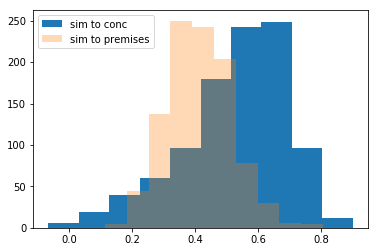

In [36]:
plt.hist(similarities_to_conclusion, label='sim to conc')
plt.hist(similarities_to_premises, label='sim to premises', alpha=.3)

plt.legend()
plt.show()